In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
from PIL import Image

In [2]:
def load_data(folder_path, skip_header=True):
    file_paths = glob.glob(os.path.join(folder_path, '*.csv'))
    data = []
    labels = []
    labelsC = []
    p1 = []
    p3 = []
    tp = []

    for file_path in file_paths:
        df = pd.read_csv(file_path, header=None, skiprows=1 if skip_header else 0, float_precision='high')
        values = df.iloc[:, :3].values  # Pegue os valores das três primeiras colunas
        label = df.iloc[0, 4]           # Pegue o rótulo da quarta coluna (considerando que é o mesmo para todas as linhas)
        labelC = label - 2
        if labelC < 0:
            labelC = 0
        tpp = df.iloc[0, 3]
        p1p = df.iloc[0, 5]
        p3p = df.iloc[0, 6]
        
        data.append(values)
        labels.append(label)
        labelsC.append(labelC)
        tp.append(tpp)
        p1.append(p1p)
        p3.append(p3p)

    data = np.array(data)
    labels = np.array(labels)
    labelsC = np.array(labelsC)
    tp = np.array(tp)
    p1 = np.array(p1)
    p3 = np.array(p3)

    return data, labels, labelsC, tp, p1, p3

In [3]:
folder_path = "E:/dataTesteDoc/train_result"
data, labelsFull, labels, tp, p1, p3 = load_data(folder_path, skip_header=True)

In [4]:
h1hl = []
h3hl = []
h3al = []
p3hl = []
resl = []
p1tl = []
p3tl = []
for i in range(len(data)):
    h1h = data[i][:, 0]
    h3h = data[i][:, 1]
    h3a = abs(data[i][:, 2]-180)/180

    h1h[np.isnan(h1h)] = 0.0
    h3h[np.isnan(h3h)] = 0.0
    h3a[np.isnan(h3a)] = 0.0

    # Verificar se o denominador é zero
    h1hz = h1h
    h1h_z = np.isclose(h1hz, 0)
    if np.any(h1h_z):
        h1hz[h1h_z] = np.nan  # Substitua os denominadores zero por NaN
    # Realizar a divisão
    p3h = np.divide(h3h, h1hz)
    
    # Aplicar condição para h1h menor que 0.1
    p3h[h1h < 0.05] = 0
    p3h = [0.0 if x < 0.03 else x-0.03 for x in p3h]
    h1h = [0.0 if x < 0.005 else x/10 for x in h1h]
    h3h = [0.0 if x < 0.001 else x/10 for x in h3h]
    h3h = np.array(h3h)
    # Realizar a decomposição
    result = sm.tsa.seasonal_decompose(h3h + 0.0001,
                                        model="mul",
                                        filt=None,
                                        period=60,
                                        two_sided=True,
                                        extrapolate_trend=0)
    
    residual = result.resid*result.trend
    res = [0 if x < 0.001 else x for x in residual]

    p1g = []
    p3g = []
    for k in range(4096):
        if (k < p1[i]-1024): 
            p1t = 0
        elif (k < p1[i]):
            p1t = 1 - ((p1[i] - k)/1024)
        else:
            p1t = 1
        if (k < p3[i]-1024): 
            p3t = 0
        elif (k < p3[i]):
            p3t = 1 - ((p3[i] - k)/1024)
        else:
            p3t = 1
        p1g.append(p1t)
        p3g.append(p3t)

    p1tl.append(p1g)
    p3tl.append(p3g)
    h1hl.append(h1h)
    h3hl.append(h3h)
    h3al.append(h3a)
    p3hl.append(p3h)
    resl.append(res)

p1tl = np.array(p1tl)
p3tl = np.array(p3tl)
h1hl = np.array(h1hl)
h3hl = np.array(h3hl)
h3al = np.array(h3al)
p3hl = np.array(p3hl)
resl = np.array(resl)

In [5]:
#plt.plot(resl[j])
#plt.plot(h3hl[j])
#plt.plot(h1hl[j])
#plt.plot(p3hl[j])
dados = np.stack((h1hl, resl, p3hl, h3al, p1tl, p3tl), axis=-1)
dados = np.nan_to_num(dados)
#print(np.isnan(dados).any())


In [6]:
def shift_data(dados, shift):
    shifted_data = np.roll(dados, shift=shift, axis=1)
    if shift > 0:  # Deslocamento para frente
        shifted_data[:, :shift, :] = np.expand_dims(dados[:, 0, :], axis=1)
    elif shift < 0:  # Deslocamento para trás
        shifted_data[:, shift:, :] = np.expand_dims(dados[:, -1, :], axis=1)
    return shifted_data


In [7]:
ruido = np.random.normal(0, 0.001, dados.shape)
dados_ruidosos = dados + ruido

dados_rep_e_rui = np.concatenate((dados, dados_ruidosos), axis=0)
tp_replicados = np.tile(tp, (2,))  # Replicar 2 vezes
labels_replicados = np.tile(labels, (2,))  # Replicar 2 vezes

# Deslocar para frente e para trás
shift_forward = 100
shift_backward = -100

dados_shifted_forward = shift_data(dados_rep_e_rui, shift_forward)
dados_shifted_backward = shift_data(dados_rep_e_rui, shift_backward)

# Combinar os dados originais, deslocados para frente e deslocados para trás
dados_aumentados = np.concatenate((dados_rep_e_rui, dados_shifted_forward, dados_shifted_backward), axis=0)
tp_aumentados = np.tile(tp_replicados, (3,))  # Replicar 2 vezes
labels_aumentados = np.tile(labels_replicados, (3,))  # Replicar 2 vezes

print(dados_aumentados.shape)  # Verificar a nova forma do conjunto de dados
print(tp_aumentados.shape)  # Verificar a nova forma do conjunto de dados
print(labels_aumentados.shape)  # Verificar a nova forma do conjunto de dados



(11064, 4096, 6)
(11064,)
(11064,)


In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Concatenate, Dropout, BatchNormalization


In [29]:
# Combine os dados de sequência e a variável numérica
dados_completos = {'sequence': dados_aumentados, 'numeric': tp_aumentados}
# Divida os dados em conjuntos de treinamento e teste
(train_data_seq, test_data_seq, train_data_num, test_data_num, train_labels, test_labels) = train_test_split(
    dados_completos['sequence'], dados_completos['numeric'], labels_aumentados, test_size=0.5, random_state=53
)

# Converta os rótulos para one-hot encoding
num_classes = 3  # Defina o número de classes
train_labels_one_hot = tf.one_hot(train_labels, depth=num_classes)
test_labels_one_hot = tf.one_hot(test_labels, depth=num_classes)

# Crie `tf.data.Dataset` para os dados de treinamento e teste, incluindo max_values
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'sequence_input': train_data_seq, 'numeric_input': train_data_num}, train_labels_one_hot)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    ({'sequence_input': test_data_seq, 'numeric_input': test_data_num},  test_labels_one_hot)
)

# Adicione a dimensão do tamanho do lote aos conjuntos de dados
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [30]:
print(np.isnan(train_data_seq).any())
print(np.isinf(train_data_seq).any())

print(np.isnan(train_data_num).any())
print(np.isinf(train_data_num).any())

False
False
False
False


In [31]:
seq_length = 4096
num_features = 6
num_classes = 3

sequence_input = Input(shape=(seq_length, num_features), name='sequence_input')
numeric_input = Input(shape=(1,), name='numeric_input')

# Sub-rede CNN para processar os dados de sequência
x = Conv1D(32, 32, activation='relu')(sequence_input)
x = MaxPooling1D(2)(x)
#x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 16, activation='relu')(x)
x = MaxPooling1D(2)(x)
#x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 8, activation='relu')(x)
x = MaxPooling1D(2)(x)
#x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(256, 4, activation='relu')(x)
x = MaxPooling1D(2)(x)
#x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)
# Combine a saída da sub-rede CNN com a variável numérica e max_values
combined = Concatenate()([x, numeric_input])
# Adicione camadas densas finais
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(num_classes, activation='softmax')(combined)

# Defina o modelo com múltiplas entradas
model = Model(inputs=[sequence_input, numeric_input], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize o resumo do modelo
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 4096, 6)]    0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 4065, 32)     6176        ['sequence_input[0][0]']         
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 2032, 32)    0           ['conv1d_8[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 2032, 32)     0           ['max_pooling1d_8[0][0]']        
                                                                                            

In [32]:
history = model.fit(
    {'sequence_input': train_data_seq, 'numeric_input': train_data_num},
    train_labels_one_hot,
    epochs=100,
    batch_size=64,
    validation_data=({'sequence_input': test_data_seq, 'numeric_input': test_data_num}, test_labels_one_hot),
)

Epoch 1/100
87/87 [==============================] - 9s 88ms/step - loss: 0.5360 - accuracy: 0.7789 - val_loss: 0.3648 - val_accuracy: 0.8590
Epoch 2/100
87/87 [==============================] - 7s 79ms/step - loss: 0.3293 - accuracy: 0.8706 - val_loss: 0.2852 - val_accuracy: 0.8986
Epoch 3/100
87/87 [==============================] - 7s 79ms/step - loss: 0.2774 - accuracy: 0.8964 - val_loss: 0.2327 - val_accuracy: 0.9205
Epoch 4/100
87/87 [==============================] - 7s 79ms/step - loss: 0.2495 - accuracy: 0.9107 - val_loss: 0.2317 - val_accuracy: 0.9084
Epoch 5/100
87/87 [==============================] - 7s 79ms/step - loss: 0.2382 - accuracy: 0.9156 - val_loss: 0.2262 - val_accuracy: 0.9291
Epoch 6/100
87/87 [==============================] - 7s 80ms/step - loss: 0.2201 - accuracy: 0.9223 - val_loss: 0.2008 - val_accuracy: 0.9215
Epoch 7/100
87/87 [==============================] - 7s 79ms/step - loss: 0.2356 - accuracy: 0.9203 - val_loss: 0.2503 - val_accuracy: 0.8990
Epoch 

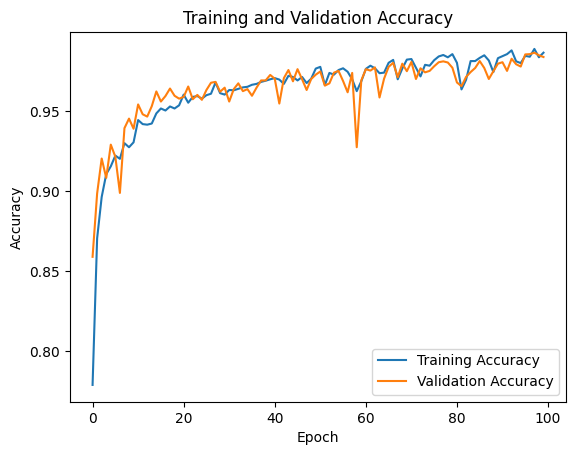

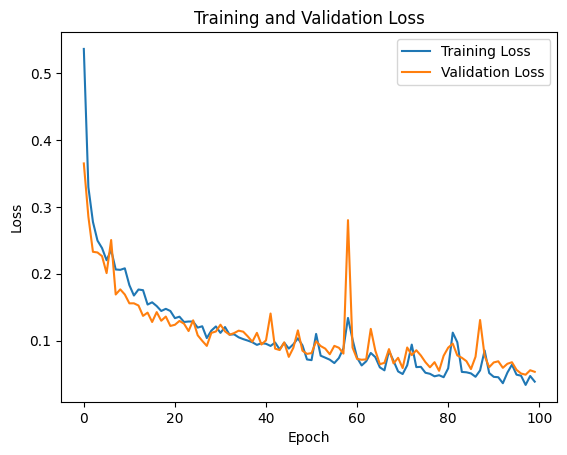

In [33]:
# Extrair métricas de treinamento
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Extrair métricas de validação
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plotar a precisão do treinamento e da validação ao longo das épocas
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotar a perda do treinamento e da validação ao longo das épocas
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
test_labels_one_hot[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>

In [38]:
# Limite de confiança para as previsões
limiar = 0.5

# A variável para armazenar o número de acertos
acertos = 0
erros = 0

#test_data_seq, test_data_num, test_labels

for sample_index in range(len(test_data_seq)):

    true_class = np.argmax(test_labels_one_hot[sample_index])

    if true_class == 2:
        new_sequence_data = test_data_seq[sample_index]
        new_numeric_data = test_data_num[sample_index]
        new_sequence_data = tf.expand_dims(new_sequence_data, axis=0)
        new_numeric_data = tf.expand_dims(new_numeric_data, axis=0)
        prediction = model.predict([new_sequence_data, new_numeric_data])
        
        # Previsão de classe
        predicted_class = np.argmax(prediction, axis=1)
        # Verifique se a previsão está correta
        if predicted_class == true_class:
            acertos += 1
        else:
            erros += 1
            
        print("Saída prevista para a amostra", sample_index, ":", predicted_class)
        print("Rótulo verdadeiro para a amostra", sample_index, ":", true_class)
        print("Valor padrao previsto", prediction)

1/1 [==============================] - 0s 22ms/step
Saída prevista para a amostra 2 : [2]
Rótulo verdadeiro para a amostra 2 : 2
Valor padrao previsto [[1.3194615e-07 5.0914364e-14 9.9999988e-01]]
1/1 [==============================] - 0s 20ms/step
Saída prevista para a amostra 3 : [2]
Rótulo verdadeiro para a amostra 3 : 2
Valor padrao previsto [[2.800873e-04 6.090948e-02 9.388104e-01]]
1/1 [==============================] - 0s 19ms/step
Saída prevista para a amostra 4 : [2]
Rótulo verdadeiro para a amostra 4 : 2
Valor padrao previsto [[1.0433443e-04 3.1182324e-08 9.9989557e-01]]
1/1 [==============================] - 0s 19ms/step
Saída prevista para a amostra 6 : [2]
Rótulo verdadeiro para a amostra 6 : 2
Valor padrao previsto [[2.0779921e-11 2.5120680e-03 9.9748790e-01]]
1/1 [==============================] - 0s 20ms/step
Saída prevista para a amostra 11 : [2]
Rótulo verdadeiro para a amostra 11 : 2
Valor padrao previsto [[1.6767230e-09 6.2364046e-03 9.9376363e-01]]
1/1 [===========

In [35]:
print(acertos)
print(erros)

2221
7


In [37]:
print(acertos)
print(erros)

1428
27


In [40]:
print(acertos)
print(erros)

1794
55


In [ ]:
# 2 -> 118 sendo 109/9
# 0 -> 143 sendo 131/12
# 1 -> 108 sendo 97/11